## OGC Web Services

The [Open Geospatial Consortium](https://www.ogc.org/) (OGC) is an international standards organisation. Its members develop and maintain standards for spatial data and services. The most well-known OGC standards are the [Geography Markup Language](https://www.ogc.org/standards/gml) (OGC GML), [GeoPackage](https://www.geopackage.org/) (OGC GPKG) and the so-called **Open Web Services** (OGC OWS), which include [Web Mapping Service](https://www.ogc.org/standards/wms) (OGC WMS), [Web Feature Service](https://www.ogc.org/standards/wfs) (OGC WFS), [Web Coverage Service](https://www.ogc.org/standards/wcs) (OGC WCS) or [Web Processing Service](https://www.ogc.org/standards/wps) (OGC WPS). Be also aware of a new initiative [OGC API](https://ogcapi.ogc.org/).

OGC OWS standards are based on server-client communication, where the client sends requests to the server. The server responds usually with an XML file. The request can either take the form of a special URL, where the individual parameters are separated by the & character, for example:

https://geoserver.opendatascience.eu/geoserver/gh/wms?request=getcapabilities&service=wms

In this case, we send 2 parameters: ``request`` has the value ``GetCapabilities`` and ``service`` has the value ``WMS``.

Another option is to send the request to the server as an XML file, for example:

`<wps:GetCapabilities xmlns:wps="http://www.opengis.net/wps/1.0.0" ...>
     <ows:Identifier>Buffer</ows:Identifier>
</wps:Execute>`

Dealing with OGC OWS can be complicated. Individual query entries vary with each version of the standards. This is one of the reasons why the [OWSLib](https://geopython.github.io/OWSLib/) library was created, which makes the life of programmers much easier.

The OWSLib library is a Python interface to the OGC OWS. The library allows you to connect to and work with various services from the client position, regardless of the server implementation. The library currently supports WMS, WFS, WCS, CSW, WPS, SOS, WaterML and other standards (the list is still growing).

## CSW

If we want to start using an OGC OWS such as WMS, we first need to know its address. Catalogue services, where specialized server applications maintain metadata records of web services and other data source, are also being created for this purpose. Communication with catalogue service is defined by OGC [Catalogue Service](https://www.ogc.org/standards/cat).

Example: [ODSE Metadata Catalogue](https://data.opendatascience.eu/geonetwork/srv/eng/catalog.search#/home) performed by GeoNetwork.

#### Connect to catalogue and check the type of the service.

In [2]:
from owslib.csw import CatalogueServiceWeb

url = "https://data.opendatascience.eu/geonetwork/srv/eng/csw?service=csw&version=2.0.2"
csw = CatalogueServiceWeb(url)
print(csw.service)

CSW


#### Check the number of metadata records available.

In [3]:
csw.getrecords2()
print(csw.results)

{'matches': 143, 'returned': 10, 'nextrecord': 11}


#### Get the titles of available metadata records.

In [5]:
# only first 10 records (!)
for rec in csw.records:
    print(csw.records[rec].title)

Short-term forecasting model ICON-D2
OSM harbours
PNV - Probability distribution for Quercus ilex
Glaciers and perpetual snow
RGB Landsat (yearly)
CORINE Land Cover
OSM quarries
Non-irrigated arable land prob. R2
OSM forest
Change Detection map of Germany 2016-2019 based on Sentinel-2 data


In [4]:
# loop over all selected records
step = 10
start_pos = 1
titles = []
while start_pos <= csw.results['matches']:
    csw.getrecords2(startposition=start_pos)
    for rec in csw.records:
        titles.append(csw.records[rec].title)
    start_pos += step
    
print(
    "Number of records:", len(titles), '\n'
    "First title:", titles[0], '\n'
    "Last title:", titles[-1]
)

Number of records: 143 
First title: OSM harbours 
Last title: OpenStreetMap WMS


#### Find records by keyword.
The filter `csw:AnyText` allows to find all records which contain anywhere the specific given string. In this case `WMS` keyword.

In [6]:
from owslib.fes import PropertyIsEqualTo

query = PropertyIsEqualTo('csw:anytext', 'WMS')
csw.getrecords2([query], esn='full')
print(csw.results)

{'matches': 115, 'returned': 10, 'nextrecord': 11}


#### Combine various filters.
In this case we combine results from previous query with another one, which search all records with `Land Cover` in their titles.


condidation1 and condition2

In [7]:
from owslib.fes import And
lc_query = PropertyIsEqualTo('csw:title', 'Land Cover')
lc_wms_query = And([query, lc_query])

csw.getrecords2([lc_wms_query], esn='full') # esn defines verbosity

print(csw.results)

{'matches': 3, 'returned': 3, 'nextrecord': 0}


#### Print selected items of searched metadata records.

In [8]:
for recid in csw.records:
    record = csw.records[recid]
    print(record.identifier, ': ',
          record.title,
          record.bbox.minx, record.bbox.miny,
          record.bbox.maxx, record.bbox.maxy)

ef733487-057f-440a-9d55-e4eac13f6fdc :  Land Cover 35.30 43.20 81.40 -11.50
769814fa-077c-4d11-976e-0ccc7d9c7f08 :  CORINE Land Cover 35.30 43.20 81.40 -11.50
be0010bb-bc1d-49a6-b6fc-f7ef488992a0 :  Land Cover Map of Europe 2017 34.00 32.00 72.00 -11.50


#### Print available online resources of the given metadata record.

In [10]:
lc = csw.records['ef733487-057f-440a-9d55-e4eac13f6fdc']
lc.references

[]

In [11]:
# Let's try ISO 19139 schema
csw.getrecords2([lc_wms_query], esn='full',
                typenames='gmd:MD_Metadata',
                outputschema="http://www.isotc211.org/2005/gmd")

lc = csw.records['ef733487-057f-440a-9d55-e4eac13f6fdc']
for ci in lc.distribution.online:
    print(ci.url)

None
https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_landcover.hcl_lucas.corine.rf_p_30m_0..0cm_2005_eumap_epsg3035_v0.1.tif
https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_landcover.hcl_lucas.corine.rf_p_30m_0..0cm_2004_eumap_epsg3035_v0.1.tif
https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_landcover.hcl_lucas.corine.rf_p_30m_0..0cm_2003_eumap_epsg3035_v0.1.tif
https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_landcover.hcl_lucas.corine.rf_p_30m_0..0cm_2002_eumap_epsg3035_v0.1.tif
https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_landcover.hcl_lucas.corine.rf_p_30m_0..0cm_2001_eumap_epsg3035_v0.1.tif
https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_landcover.hcl_lucas.corine.rf_p_30m_0..0cm_2000_eumap_epsg3035_v0.1.tif
https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_landcover.hcl_lucas.corine.rf_p_30m_0..0cm_2011_eumap_epsg3035_v0.1.tif
https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_landcover.hcl_lucas.corine.rf_p_30m_0..0cm_2010_eumap_epsg3035_v0.1.tif
htt

/home/opengeohub/.local/lib/python3.8/site-packages/owslib/iso.py:118: FutureWarning: the .identification and .serviceidentification properties will merge into .identification being a list of properties.  This is currently implemented in .identificationinfo.  Please see https://github.com/geopython/OWSLib/issues/38 for more information
  warnings.warn(
/home/opengeohub/.local/lib/python3.8/site-packages/owslib/iso.py:552: FutureWarning: The .keywords and .keywords2 properties will merge into the .keywords property in the future, with .keywords becoming a list of MD_Keywords instances. This is currently implemented in .keywords2. Please see https://github.com/geopython/OWSLib/issues/301 for more information
  warnings.warn(


Unfortunately we received online resources pointing to GeoTIFF files instead of desired WMS URL. In the next part a *ODSE Mapserver* will be used for demostration.

## WMS
**OGC Web Map Service** is used to download and share map data. The server is not sending the actual data, but only a preview (image) of the data.

Example [ODSE Mapserver](https://data.opendatascience.eu/geoserver/web/)

#### Connect to WMS and print the information about the service.

Request GetCapabilities: https://geoserver.opendatascience.eu/geoserver/gh/wms?request=getcapabilities&service=wms

In [12]:
from owslib.wms import WebMapService

url = "https://geoserver.opendatascience.eu/geoserver/gh/wms"

wms = WebMapService(url)
print(wms.identification.title, '\n',
      wms.identification.abstract, '\n',
      wms.provider.name, '\n',
      wms.provider.contact.address)

GeoServer Web Map Service 
 A compliant implementation of WMS plus most of the SLD extension (dynamic styling). Can also generate PDF, SVG, KML, GeoRSS 
 The Ancient Geographers 
 None


#### Print the names of all available layers.

In [13]:
for item in wms.contents:
    print(item)

NUTS_RG_01M_2021_4326_LEVL_3
S2GLC_Europe_2017_v1.2_edited
adm_county_nuts.osm_c_30m_0..0cm_2021_eumap_epsg3035_v0.1
adm_protected.area_natura2000.osm_p_30m_0..0cm_2019..2021_eumap_epsg3035_v0.1
clm-airXtemp-era5Xcopernicus-av-1km-200XX200cm--eumap-epsg3035-v0X1
clm-airXtemp-era5Xcopernicus-mn-1km-200XX200cm--eumap-epsg3035-v0X1
clm-airXtemp-era5Xcopernicus-mx-1km-200XX200cm--eumap-epsg3035-v0X1
clm-prec-era5Xcopernicus-sum-1km-200XX200cm--eumap-epsg3035-v0X1
clm-skinXtemp-era5Xcopernicus-av-1km-0XX0cm--eumap-epsg3035-v0X1
clm-skinXtemp-era5Xcopernicus-mn-1km-0XX0cm--eumap-epsg3035-v0X1
clm-skinXtemp-era5Xcopernicus-mx-1km-0XX0cm--eumap-epsg3035-v0X1
dtm_elev.lowestmode_gedi.eml_md_30m_0..0cm_2000..2018_eumap_epsg3035_v0.3
dtm_elev.lowestmode_gedi.eml_mf_30m_0..0cm_2000..2018_eumap_epsg3035_v0.3
dtm_hillshade.a315_gedi.eml_mf_30m_0..0cm_2000..2018_eumap_epsg3035_v0.3
dtm_slope.percent_gedi.eml_m_30m_0..0cm_2000..2018_eumap_epsg3035_v0.3
dtm_topidx_gedi.eml_m_50m_0..0cm_2000..2018_eumap

#### Get layer by name a print its bounding box.

In [15]:
layer = "lcv-landcoverXhcl-lucasXcorineXrf-p-30m"
print(wms.contents[layer].boundingBox, '\n',
      wms.contents[layer].boundingBoxWGS84)

(900000.0, 930010.0, 6540000.0, 5460010.0, 'EPSG:3035') 
 (-55.96179950225132, 24.535732807579436, 61.09769682534348, 71.61287163723048)


#### Get layer by bbox and show the preview (image).

Request GetMap: https://geoserver.opendatascience.eu/geoserver/gh/wms?request=getmap&service=wms&version=1.3.0&layers=lcv-landcoverXhcl-lucasXcorineXrf-p-30m&CRS=EPSG:3035&width=800&height=600&format=image/png&bbox=900000.0,930010.0,6540000.0,5460010.0

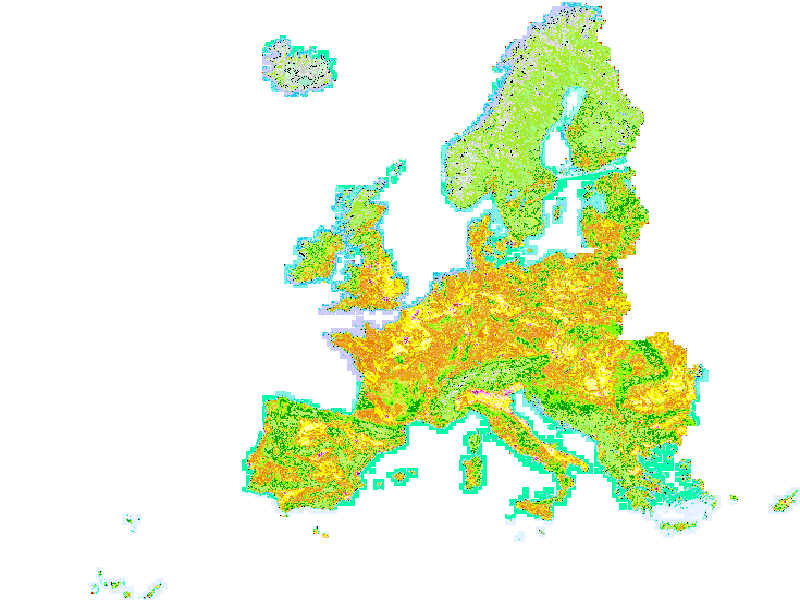

In [16]:
from IPython.display import Image

img = wms.getmap(
    layers=[layer],
    size=[800, 600],
    srs="EPSG:3035",
    bbox=[900000.0, 930010.0, 6540000.0, 5460010.0],
    format="image/png"
)

Image(img.read())

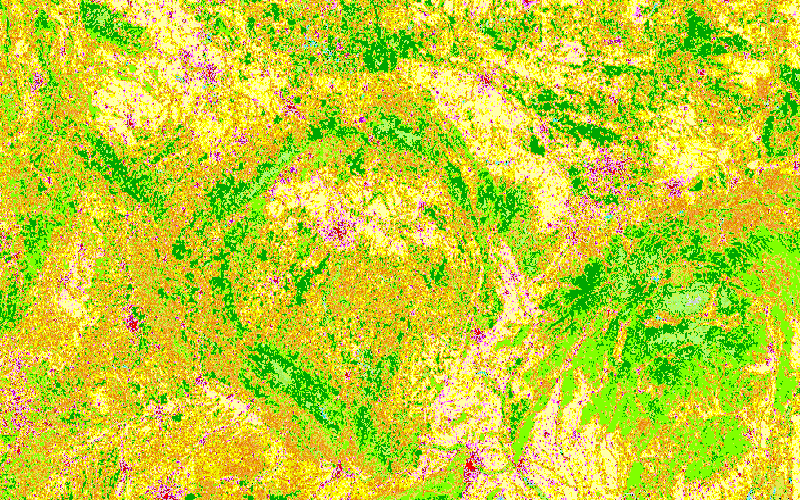

In [17]:
img = wms.getmap(
    layers=[layer],
    size=[800, 500],
    srs="EPSG:3035",
    bbox=[4240841.4, 2779050.3, 5180968.8, 3201353.5],
    format="image/png"
)

Image(img.read())